# Analyzing and predicting Service Request Types in DC

The flow adopted in this notebook is as follows:

> 1. Read in the datasets using ArcGIS API for Python
> 2. Merge datasets
> 3. Construct model that predicts service type
> 4. How many requests does each neighborhood make?
> 5. What kind of requests does each neighborhood mostly make?
> 6. Next Steps

The datasets used in this notebook are the 
1. __`City Service Requests in 2018`__
2. __`Neighborhood Clusters`__

These datasets can be found at [opendata.dc.gov](http://opendata.dc.gov/)

We start by importing the ArcGIS package to load the data using a service URL

In [1]:
import arcgis
from arcgis.features import *


### 1.1 Read in service requests for 2018

[Link](http://opendata.dc.gov/datasets/city-service-requests-in-2018/geoservice?geometry=-77.49%2C38.811%2C-76.534%2C38.998) to Service Requests 2018 dataset

In [2]:
requests_url = 'https://maps2.dcgis.dc.gov/dcgis/rest/services/DCGIS_DATA/ServiceRequests/MapServer/9'

requests_layer = FeatureLayer(requests_url)
requests_layer

<FeatureLayer url:"https://maps2.dcgis.dc.gov/dcgis/rest/services/DCGIS_DATA/ServiceRequests/MapServer/9">

In [3]:
# Extract all the data and display number of rows
requests_features = requests_layer.query()
print('Total number of rows in the dataset: ')
print(len(requests_features.features))

KeyboardInterrupt: 

This dataset updates on runtime, hence the number of rows could vary each time.

In [ ]:
# store as dataframe
requests = requests_features.sdf

# View first 5 rows
requests.head()

### 1.2 Read in Neighborhood Clusters dataset

[Link](http://opendata.dc.gov/datasets/neighborhood-clusters) to this dataset

In [ ]:
neighborhood_url = 'https://maps2.dcgis.dc.gov/dcgis/rest/services/DCGIS_DATA/Administrative_Other_Boundaries_WebMercator/MapServer/17'

neighborhood_layer = FeatureLayer(neighborhood_url)
neighborhood_layer

In [ ]:
# Extract all the data and display number of rows
neighborhood_features = neighborhood_layer.query()
print('Total number of rows in the dataset: ')
print(len(neighborhood_features.features))

In [ ]:
# store as dataframe
neighborhood = neighborhood_features.sdf

# View first 5 rows
neighborhood.head()

We now __merge__ the two datasets

In [ ]:
# Connect to the GIS
from arcgis.gis import GIS
gis = GIS('http://dcdev.maps.arcgis.com/', 'username', 'password')

In [9]:
# Perform spatial join between CBG layer and the service areas created for all time durations
requests_with_neighborhood = arcgis.features.analysis.join_features(requests_url, neighborhood_url, spatial_relationship='Intersects', output_name='serviceRequests_Neighborhood_DC_1')

In [10]:
requests_with_neighborhood.share(everyone=True)

{'itemId': '21ecb944fdc3495ea23e8cee411d0e29', 'notSharedWith': []}

In [11]:
requests_with_neighborhood_url = str(requests_with_neighborhood.url)+'/0/'
layer = FeatureLayer(requests_with_neighborhood_url)
features = layer.query()
print('Total number of rows in the dataset: ')
print(len(features.features))

Total number of rows in the dataset: 
80957


In [12]:
merged = features.sdf
merged.head()

,ADDDATE,CITY,DETAILS,INSPECTIONDATE,INSPECTIONFLAG,INSPECTORNAME,Join_Count,LATITUDE,LONGITUDE,MARADDRESSREPOSITORYID,...,STATE,STATUS_CODE,STREETADDRESS,TYPE,WARD,WEB_URL,XCOORD,YCOORD,ZIPCODE,SHAPE
0,1514882874000,WASHINGTON,jg - Not Found – Close SR,NaN,N,None,1,38.894965,-76.935862,19821.0,...,DC,CLOSED,4531 EADS STREET NE,Original,7,http://planning.dc.gov/,405564.01,136348.29,20019.0,"{'x': 405564.0099999979, 'y': 136348.2899999991}"
1,1514883836000,WASHINGTON,am - Collected – Close SR,NaN,N,None,1,38.966837,-77.077571,285265.0,...,DC,CLOSED,5727 WESTERN AVENUE NW,Original,3,http://planning.dc.gov/,393277.48,144327.59,20015.0,"{'x': 393277.4799999967, 'y': 144327.58999999985}"
2,1514877377000,WASHINGTON,None,NaN,N,None,1,38.909417,-77.040607,238156.0,...,DC,CLOSED,1750 P STREET NW,Original,2,http://planning.dc.gov/,396478.07,137951.41,20036.0,"{'x': 396478.0700000003, 'y': 137951.41000000015}"
3,1514882441000,WASHINGTON,Per T. Duckett 1-9-18. closed by A .Hedgeman 0...,1.515497e+12,Y,None,1,38.927450,-77.097581,224717.0,...,DC,CLOSED,2895 UNIVERSITY TERRACE NW,Original,3,http://planning.dc.gov/,391538.72,139956.98,20016.0,"{'x': 391538.7199999988, 'y': 139956.98000000045}"
4,1514882008000,WASHINGTON,Collect on 1-6-18 by A.Hill,NaN,N,None,1,38.862290,-76.989317,67895.0,...,DC,CLOSED,1319 MAPLE VIEW PLACE SE,Original,8,http://planning.dc.gov/,400927.19,132719.19,20020.0,"{'x': 400927.1899999976, 'y': 132719.19000000134}"


### 3. Construct model that predicts service type

The variables used to build the model are:
> 1. City Quadrant
> 2. Neighborhood cluster
> 3. Ward (Geographical unit)
> 4. Organization acronym
> 5. Status Code

### 3.1 Data preprocessing

In [13]:
quads = ['NE', 'NW', 'SE', 'SW']
def generate_quadrant(x):
    '''Function that extracts quadrant from street address'''
    try:
        temp = x[-2:]
        if temp in quads:
            return temp
        else:
            return 'NaN'
    except:
        return 'NaN'

In [14]:
merged['QUADRANT'] = merged['STREETADDRESS'].apply(generate_quadrant)
merged['QUADRANT'].head()

0    NE
1    NW
2    NW
3    NW
4    SE
Name: QUADRANT, dtype: object

In [15]:
merged['QUADRANT'].unique()

array(['NE', 'NW', 'SE', 'NaN', 'SW'], dtype=object)

In [16]:
merged['CLUSTER'] = merged['NAME'].apply(lambda x: x[8:])
merged['CLUSTER'].head()

0    30
1    10
2     6
3    13
4    28
Name: CLUSTER, dtype: object

In [17]:
merged['CLUSTER'] = merged['CLUSTER'].astype(int)

In [18]:
merged['ORGANIZATIONACRONYM'].unique()

array(['DPW', 'DDOT', 'FEMS', 'DOH', 'OUC', 'DOEE', 'DMV', 'ORM',
       'DC-ICH', 'DDS'], dtype=object)

In [19]:
merged['STATUS_CODE'].unique()

array(['CLOSED', 'OPEN'], dtype=object)

Let's extract the number of possible outcomes, i.e. length of the target variable and also take a look at the values

In [20]:
len(merged['SERVICETYPECODEDESCRIPTION'].unique())

23

In [21]:
requests['SERVICETYPECODEDESCRIPTION'].unique()

array(['SNOW', 'PEMA- Parking Enforcement Management Administration',
       'Toa-Street & Bridge Maintenance', 'Urban Forrestry',
       'SWMA- Solid Waste Management Admistration',
       'Transportation Operations Administration', 'SIOD',
       'Department of Transportation', 'Driver Vehicle Services',
       'Toa-Trans Sys Mnt-Signs', 'Toa- Trans Sys Mnt',
       'DOH- Department Of Health', 'Tru-311',
       'Transportation Policy & Planning Administration',
       'FEMS-Smoke Alarms', 'FEMS-Special Events',
       'Department of Energy and Environment', 'Adjudication Services',
       '311- Call Center', 'HOMYDRPR- How Is My Driving Program',
       'DC Interagency Council on Homelessness', '311- Emergencies',
       'Department of Disability Services'], dtype=object)

### 3.2 Model building

In [22]:
# Import necessary packages
from sklearn.preprocessing import *
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [23]:
# Convert categorical (text) fields to numbers
number = LabelEncoder()
merged['SERVICETYPE_NUMBER'] = number.fit_transform(merged['SERVICETYPECODEDESCRIPTION'].astype('str'))
merged['STATUS_CODE_NUMBER'] = number.fit_transform(merged['STATUS_CODE'].astype('str'))

In [24]:
# Extract desired fields
data = merged[['SERVICETYPECODEDESCRIPTION', 'SERVICETYPE_NUMBER', 'QUADRANT', 'CLUSTER', 'WARD', 'ORGANIZATIONACRONYM', 'STATUS_CODE', 'STATUS_CODE_NUMBER']]
data.reset_index(inplace=True)
data.head()

,index,SERVICETYPECODEDESCRIPTION,SERVICETYPE_NUMBER,QUADRANT,CLUSTER,WARD,ORGANIZATIONACRONYM,STATUS_CODE,STATUS_CODE_NUMBER
0,0,SWMA- Solid Waste Management Admistration,15,NE,30,7,DPW,CLOSED,0
1,1,SWMA- Solid Waste Management Admistration,15,NW,10,3,DPW,CLOSED,0
2,2,PEMA- Parking Enforcement Management Administr...,12,NW,6,2,DPW,CLOSED,0
3,3,SNOW,14,NW,13,3,DPW,CLOSED,0
4,4,SWMA- Solid Waste Management Admistration,15,SE,28,8,DPW,CLOSED,0


Let's binarize values in fields `QUADRANT` (4) and `ORGANIZATIONACRONYM` (8)

Wonder why are not doing it for `CLUSTER`? Appropriate nomenclature of [adjacent clusters](http://opendata.dc.gov/datasets/neighborhood-clusters).

In [25]:
import pandas as pd
data = pd.get_dummies(data=data, columns=['QUADRANT', 'ORGANIZATIONACRONYM'])
data.head()

,index,SERVICETYPECODEDESCRIPTION,SERVICETYPE_NUMBER,CLUSTER,WARD,STATUS_CODE,STATUS_CODE_NUMBER,QUADRANT_NE,QUADRANT_NW,QUADRANT_NaN,...,ORGANIZATIONACRONYM_DC-ICH,ORGANIZATIONACRONYM_DDOT,ORGANIZATIONACRONYM_DDS,ORGANIZATIONACRONYM_DMV,ORGANIZATIONACRONYM_DOEE,ORGANIZATIONACRONYM_DOH,ORGANIZATIONACRONYM_DPW,ORGANIZATIONACRONYM_FEMS,ORGANIZATIONACRONYM_ORM,ORGANIZATIONACRONYM_OUC
0,0,SWMA- Solid Waste Management Admistration,15,30,7,CLOSED,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1,SWMA- Solid Waste Management Admistration,15,10,3,CLOSED,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,2,PEMA- Parking Enforcement Management Administr...,12,6,2,CLOSED,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,3,SNOW,14,13,3,CLOSED,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,4,SWMA- Solid Waste Management Admistration,15,28,8,CLOSED,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [26]:
# Extract input dataframe
model_data = data.drop(['SERVICETYPECODEDESCRIPTION', 'SERVICETYPE_NUMBER', 'STATUS_CODE'], axis=1)
model_data.head()

,index,CLUSTER,WARD,STATUS_CODE_NUMBER,QUADRANT_NE,QUADRANT_NW,QUADRANT_NaN,QUADRANT_SE,QUADRANT_SW,ORGANIZATIONACRONYM_DC-ICH,ORGANIZATIONACRONYM_DDOT,ORGANIZATIONACRONYM_DDS,ORGANIZATIONACRONYM_DMV,ORGANIZATIONACRONYM_DOEE,ORGANIZATIONACRONYM_DOH,ORGANIZATIONACRONYM_DPW,ORGANIZATIONACRONYM_FEMS,ORGANIZATIONACRONYM_ORM,ORGANIZATIONACRONYM_OUC
0,0,30,7,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,1,10,3,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
2,2,6,2,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
3,3,13,3,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
4,4,28,8,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0


In [27]:
def handle_ward(x):
    accept = [range(0,8)]
    if x not in accept:
        return 0
    else:
        return x

In [28]:
model_data['WARD'] = model_data['WARD'].apply(handle_ward)

In [29]:
# Define independent and dependent variables
y = data['SERVICETYPE_NUMBER'].values
X = model_data.values

In [30]:
# Split data into training and test samples of 70%-30%
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .3, random_state=522, stratify=y)

In [31]:
# n_estimators = number of trees in the forest
# min_samples_leaf = minimum number of samples required to be at a leaf node for the tree
rf = RandomForestClassifier(n_estimators=2500, min_samples_leaf=5, random_state=522)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(y_pred)

[15 15 12 ... 15 21 15]


In [32]:
print('Accuracy: ', accuracy_score(y_test, y_pred))

Accuracy:  0.6824769433465085


### 3.3 Alternate model, excluding the department codes

In [33]:
data = merged[['SERVICETYPECODEDESCRIPTION', 'SERVICETYPE_NUMBER', 'QUADRANT', 'CLUSTER', 'WARD', 'ORGANIZATIONACRONYM', 'STATUS_CODE', 'STATUS_CODE_NUMBER']]
data.reset_index(inplace=True)
data.head()

,index,SERVICETYPECODEDESCRIPTION,SERVICETYPE_NUMBER,QUADRANT,CLUSTER,WARD,ORGANIZATIONACRONYM,STATUS_CODE,STATUS_CODE_NUMBER
0,0,SWMA- Solid Waste Management Admistration,15,NE,30,7,DPW,CLOSED,0
1,1,SWMA- Solid Waste Management Admistration,15,NW,10,3,DPW,CLOSED,0
2,2,PEMA- Parking Enforcement Management Administr...,12,NW,6,2,DPW,CLOSED,0
3,3,SNOW,14,NW,13,3,DPW,CLOSED,0
4,4,SWMA- Solid Waste Management Admistration,15,SE,28,8,DPW,CLOSED,0


In [34]:
data1 = pd.get_dummies(data=data,columns=['QUADRANT'])
data1.head()

,index,SERVICETYPECODEDESCRIPTION,SERVICETYPE_NUMBER,CLUSTER,WARD,ORGANIZATIONACRONYM,STATUS_CODE,STATUS_CODE_NUMBER,QUADRANT_NE,QUADRANT_NW,QUADRANT_NaN,QUADRANT_SE,QUADRANT_SW
0,0,SWMA- Solid Waste Management Admistration,15,30,7,DPW,CLOSED,0,1,0,0,0,0
1,1,SWMA- Solid Waste Management Admistration,15,10,3,DPW,CLOSED,0,0,1,0,0,0
2,2,PEMA- Parking Enforcement Management Administr...,12,6,2,DPW,CLOSED,0,0,1,0,0,0
3,3,SNOW,14,13,3,DPW,CLOSED,0,0,1,0,0,0
4,4,SWMA- Solid Waste Management Admistration,15,28,8,DPW,CLOSED,0,0,0,0,1,0


In [35]:
model_data1 = data1.drop(['SERVICETYPECODEDESCRIPTION', 'SERVICETYPE_NUMBER', 'STATUS_CODE', 'ORGANIZATIONACRONYM'], axis=1)
model_data1.head()

,index,CLUSTER,WARD,STATUS_CODE_NUMBER,QUADRANT_NE,QUADRANT_NW,QUADRANT_NaN,QUADRANT_SE,QUADRANT_SW
0,0,30,7,0,1,0,0,0,0
1,1,10,3,0,0,1,0,0,0
2,2,6,2,0,0,1,0,0,0
3,3,13,3,0,0,1,0,0,0
4,4,28,8,0,0,0,0,1,0


In [36]:
model_data1['WARD'] = model_data1['WARD'].apply(handle_ward)

In [37]:
y = data['SERVICETYPE_NUMBER'].values
X = model_data1.values

In [38]:
# Split data into training and test samples of 70%-30%
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .3, random_state=522, stratify=y)

In [39]:
# n_estimators = number of trees in the forest
# min_samples_leaf = minimum number of samples required to be at a leaf node for the tree
rf = RandomForestClassifier(n_estimators=2500, min_samples_leaf=5, random_state=522)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(y_pred)

[15 15 12 ... 15 15 15]


In [40]:
print('Accuracy: ', accuracy_score(y_test, y_pred))

Accuracy:  0.4862895256916996


A drop in accuracy from __68.39%__ to __48.78%__ demonstrates the importance of using the correct predictors.

### 4. How many requests does each neighborhood make?

In [41]:
# Count of service requests per cluster
cluster_count = merged.groupby('NAME').size().reset_index(name='counts')
cluster_count.head()

,NAME,counts
0,Cluster 1,1991
1,Cluster 10,1707
2,Cluster 11,2475
3,Cluster 12,767
4,Cluster 13,1625


In [42]:
# merge with original file
neighborhood = pd.merge(neighborhood, cluster_count, on='NAME')
neighborhood.head()

,NAME,NBH_NAMES,OBJECTID,Shape_Area,Shape_Length,TYPE,WEB_URL,SHAPE,counts
0,Cluster 39,"Congress Heights, Bellevue, Washington Highlands",1,4.886463e+06,10711.668010,Original,http://planning.dc.gov/,"{'rings': [[[-8570934.978117127, 4699521.51243...",2360
1,Cluster 38,"Douglas, Shipley Terrace",2,2.367958e+06,8229.486324,Original,http://planning.dc.gov/,"{'rings': [[[-8568786.426828014, 4700618.41227...",733
2,Cluster 36,"Woodland/Fort Stanton, Garfield Heights, Knox ...",3,1.119573e+06,4746.344457,Original,http://planning.dc.gov/,"{'rings': [[[-8568124.617559846, 4701733.64556...",378
3,Cluster 27,"Near Southeast, Navy Yard",4,1.619167e+06,7286.968902,Original,http://planning.dc.gov/,"{'rings': [[[-8570182.535376322, 4704085.08115...",480
4,Cluster 32,"River Terrace, Benning, Greenway, Dupont Park",5,4.286254e+06,11251.012821,Original,http://planning.dc.gov/,"{'rings': [[[-8564654.618529493, 4705921.46259...",1285


In [43]:
temp = neighborhood.sort_values(['counts'], ascending=[False])
temp[['NAME', 'NBH_NAMES', 'counts']]

,NAME,NBH_NAMES,counts
33,Cluster 2,"Columbia Heights, Mt. Pleasant, Pleasant Plain...",5291
30,Cluster 25,"Union Station, Stanton Park, Kingman Park",5277
20,Cluster 18,"Brightwood Park, Crestwood, Petworth",5137
13,Cluster 6,"Dupont Circle, Connecticut Avenue/K Street",4629
38,Cluster 26,"Capitol Hill, Lincoln Park",3876
5,Cluster 8,"Downtown, Chinatown, Penn Quarters, Mount Vern...",3763
32,Cluster 21,"Edgewood, Bloomingdale, Truxton Circle, Eckington",3554
21,Cluster 11,"Friendship Heights, American University Park, ...",2475
23,Cluster 17,"Takoma, Brightwood, Manor Park",2467
6,Cluster 5,"West End, Foggy Bottom, GWU",2445


<Item title:"Neighborhood_Service_Requests" type:Web Map owner:mmajumdar_dcdev>
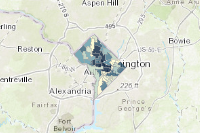

In [44]:
# Viewing the map
search_result = gis.content.search("Neighborhood_Service_Requests")
search_result[0]

### 5. What kind of requests does each neighborhood mostly make?

In [45]:
import scipy.stats
merged.columns

Index(['ADDDATE', 'CITY', 'DETAILS', 'INSPECTIONDATE', 'INSPECTIONFLAG',
       'INSPECTORNAME', 'Join_Count', 'LATITUDE', 'LONGITUDE',
       'MARADDRESSREPOSITORYID', 'NAME', 'NBH_NAMES', 'OBJECTID',
       'ORGANIZATIONACRONYM', 'PRIORITY', 'RESOLUTIONDATE', 'SERVICECALLCOUNT',
       'SERVICECODE', 'SERVICECODEDESCRIPTION', 'SERVICEDUEDATE',
       'SERVICEORDERDATE', 'SERVICEORDERSTATUS', 'SERVICEREQUESTID',
       'SERVICETYPECODEDESCRIPTION', 'STATE', 'STATUS_CODE', 'STREETADDRESS',
       'TYPE', 'WARD', 'WEB_URL', 'XCOORD', 'YCOORD', 'ZIPCODE', 'SHAPE',
       'QUADRANT', 'CLUSTER', 'SERVICETYPE_NUMBER', 'STATUS_CODE_NUMBER'],
      dtype='object')

In [46]:
df = merged[['NAME', 'SERVICECODEDESCRIPTION']]

In [47]:
# Extract the most frequently occuring service request type, and its count
df1 = df.groupby('NAME').agg(lambda x: scipy.stats.mode(x)[0][0])
df2 = df.groupby('NAME').agg(lambda x: scipy.stats.mode(x)[1][0])

C:\Users\manu9321\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


In [48]:
df1.reset_index(inplace=True)
df2.reset_index(inplace=True)
df2 = df2.rename(columns={'SERVICECODEDESCRIPTION':'SERVICECODEDESCRIPTION_COUNT'})

In [49]:
# merge the two datasets
final_df = pd.merge(df1, df2, on='NAME')
final_df.head()

,NAME,SERVICECODEDESCRIPTION,SERVICECODEDESCRIPTION_COUNT
0,Cluster 1,Parking Enforcement,383
1,Cluster 10,Bulk Collection,342
2,Cluster 11,Parking Meter Repair,863
3,Cluster 12,Roadway Signs,111
4,Cluster 13,Pothole,254


In [50]:
# merge it with neighborhood clusters
neighborhood_data = pd.merge(neighborhood, final_df, on='NAME')

In [51]:
# view the map
search_result = gis.content.search("Neighborhood_Service_DC")
search_result[0]

<Item title:"Neighborhood_Service_DC" type:Web Map owner:mmajumdar_dcdev>